In [1]:
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from cosine_annealing import CosineAnnealingScheduler
from keras.layers import BatchNormalization
import pickle
from keras.regularizers import l2
from  scipy import ndimage
import numpy as np

#### Dataset


Load dataset + One-hot encoding + Normalization

In [2]:
def load_dataset(noise_ratio=0, sym=True):
    (trainX, trainY), (testX, testY) = cifar10.load_data()
    n_classes = 10

    if noise_ratio > 0:
        trainY_original = np.copy(trainY)
        if not sym:
            # Asymetric noise
            source_class = [9, 2, 3, 5, 4]
            target_class = [1, 0, 5, 3, 7]

            for s, t in zip(source_class, target_class):
                cls_idx = np.where(trainY_original == s)[0]
                n_noisy = int(noise_ratio * cls_idx.shape[0] / 100)
                noisy_sample_index = np.random.choice(cls_idx, n_noisy, replace=False)
                trainY[noisy_sample_index] = t
        else:
          # Symmetric noise

            n_samples = trainY.shape[0]
            n_noisy = int(noise_ratio * n_samples / 100)
            class_index = [np.where(trainY_original == i)[0] for i in range(n_classes)]
            class_noisy = int(n_noisy / n_classes)

            noisy_idx = []
            for d in range(n_classes):
                noisy_class_index = np.random.choice(class_index[d], class_noisy, replace=False)
                noisy_idx.extend(noisy_class_index)

            for i in noisy_idx:
                class_ind = trainY_original[i]
                other_class_list = list(range(n_classes))
                other_class_list.remove(class_ind)
                other_class = np.random.choice(other_class_list)
                trainY[i] = other_class

    # One-hot encoding
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    # Normalize to [0,1]
    trainX = trainX.astype('float32') / 255.0
    testX = testX.astype('float32') / 255.0

    train_mean = trainX.mean((0,1,2))
    train_std = trainX.std((0,1,2))

    trainX = (trainX - train_mean)# / train_std

    test_mean = testX.mean((0,1,2))
    test_std = testX.std((0,1,2))

    testX = (testX - test_mean)# / test_std

    return trainX, trainY, testX, testY

#### Model

Imortant functions

In [3]:

def train(model, trainX, trainY, testX, testY):

	generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

	train_data = generator.flow(trainX, trainY, batch_size=64)

	results = model.fit(train_data, epochs=100, validation_data=(testX, testY), verbose=1)

	return results

def evaluate(model, testX, testY):
    _, acc = model.evaluate(testX, testY, verbose=0)

    print(f"The model achieved a final accuracy of {acc*100:.2f}%")

def plot_results(history):
	plt.title('Symmetric Cross Entropy Loss')
	plt.plot(history['loss'], color='blue', label='Training loss')
	plt.plot(history['val_loss'], color='orange', label='Validation/test loss')
	plt.legend()
	plt.show()

	plt.title('Classification Accuracy')
	plt.plot(history['accuracy'], color='blue', label='Training accuracy')
	plt.plot(history['val_accuracy'], color='orange', label='Validation/test accuracy')
	plt.legend()
	plt.show()

In [4]:
def save_model(filename, model):
    filename = '/content/' + filename
    pickle.dump(model, open(filename, 'wb'))

def save_history(filename, history):
    filename = '/content/' + filename
    pickle.dump(history, open(filename, 'wb'))

def load_model(filename):
    filename = '/content/' + filename
    model = pickle.load(open(filename, 'rb'))
    return model

def load_history(filename):
    filename = '/contents/' + filename
    history = pickle.load(open(filename, 'rb'))
    return history

SL loss function

https://github.com/YisenWang/symmetric_cross_entropy_for_noisy_labels/blob/master/loss.py

In [5]:
def symmetric_cross_entropy(y_true, y_pred):
    alpha = 0.1
    beta = 1.0
    y_true_1 = y_true
    y_pred_1 = y_pred

    y_true_2 = y_true
    y_pred_2 = y_pred

    y_pred_1 = tf.clip_by_value(y_pred_1, 1e-7, 1.0)
    y_true_2 = tf.clip_by_value(y_true_2, 1e-4, 1.0)

    return alpha*tf.math.reduce_mean(-tf.math.reduce_sum(y_true_1 * tf.math.log(y_pred_1), axis = -1)) + beta*tf.math.reduce_mean(-tf.math.reduce_sum(y_pred_2 * tf.math.log(y_true_2), axis = -1))


Baseline model

In [6]:
def dropout_model():
    # Create architecture
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3), kernel_regularizer=l2(5e-4)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(5e-4)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(5e-4)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(5e-4)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(5e-4)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(5e-4)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(5e-4)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    total_steps = int(trainX.shape[0]/64) * 100
    decay_steps = total_steps*0.8
    initial_learning_rate = 0.01
    warmup_steps = 1000
    target_learning_rate = 0.1
    alpha_2 = 0.001

    lr_warmup_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate, decay_steps ,alpha = alpha_2
    )
    # Optimization method
    opt = SGD(learning_rate=lr_warmup_decayed_fn, momentum=0.9)

    # Compile model and choose loss type
    model.compile(optimizer=opt, loss=symmetric_cross_entropy, metrics=['accuracy'])
    return model

In [7]:
trainX, trainY, testX, testY = load_dataset(noise_ratio=40, sym=True)

170498071/170498071 [==============================] - 3s 0us/step


In [8]:
model = dropout_model()
results = train(model, trainX, trainY, testX, testY)

Epoch 1/100
782/782 [==============================] - 41s 42ms/step - loss: 8.2919 - accuracy: 0.2278 - val_loss: 6.3742 - val_accuracy: 0.4244
Epoch 2/100
782/782 [==============================] - 33s 42ms/step - loss: 7.7735 - accuracy: 0.2878 - val_loss: 5.8621 - val_accuracy: 0.4741
Epoch 3/100
782/782 [==============================] - 32s 41ms/step - loss: 7.4723 - accuracy: 0.3200 - val_loss: 5.6193 - val_accuracy: 0.5021
Epoch 4/100
782/782 [==============================] - 32s 40ms/step - loss: 7.2407 - accuracy: 0.3448 - val_loss: 4.9961 - val_accuracy: 0.5624
Epoch 5/100
782/782 [==============================] - 32s 41ms/step - loss: 7.0503 - accuracy: 0.3646 - val_loss: 4.6667 - val_accuracy: 0.5993
Epoch 6/100
782/782 [==============================] - 31s 40ms/step - loss: 6.8810 - accuracy: 0.3806 - val_loss: 4.1990 - val_accuracy: 0.6488
Epoch 7/100
782/782 [==============================] - 32s 41ms/step - loss: 6.7637 - accuracy: 0.3921 - val_loss: 4.1008 - val_ac

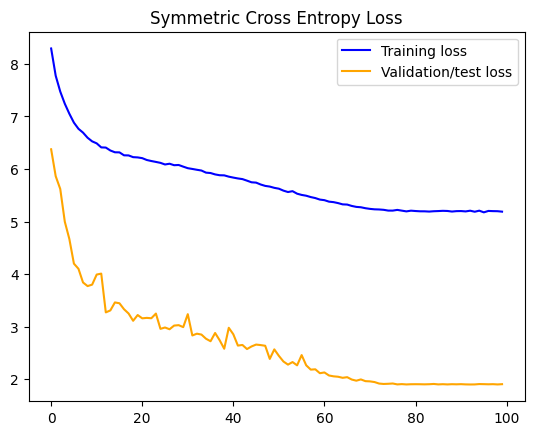

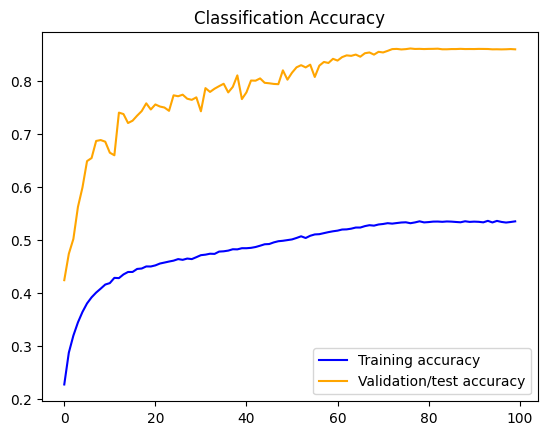

The model achieved a final accuracy of 85.95%


In [9]:
plot_results(results.history)
evaluate(model, testX, testY)

In [11]:
save_model('SL_noisy_model_40_sym_dropout', model)
save_history('SL_noisy_model_40_sym_dropout_hist', results.history)